In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

# Ingesting data
con = sqlite3.connect("csgo.db")
csgo_df = pd.read_sql_query("SELECT * FROM round INNER JOIN game WHERE round.game_id = game.id", con, parse_dates=["time"])
players_df = pd.read_sql_query("SELECT * from players", con)
csgo_df['time'] = pd.to_datetime(csgo_df['time'], utc=True)

# Some Pandas visual display options to read the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Creating some summary variables

In [2]:
csgo_df['survivingCount'] =  csgo_df.survivingPlayers.apply(lambda x: len(x[1:-1].split(',')) if x != 'null' else 0)
csgo_df['longestKillWaitS'] = csgo_df['longestKillWait']/csgo_df['tickrate']
csgo_df['lastKillToEndS'] = csgo_df['lastKillToEnd']/csgo_df['tickrate']
csgo_df["team_a_players_str"] = csgo_df.team_a_players.apply(lambda x: str(sorted(x[1:-1].split(','))))
csgo_df["team_b_players_str"] = csgo_df.team_b_players.apply(lambda x: str(sorted(x[1:-1].split(','))))
csgo_df["team_a_players"] = csgo_df.team_a_players.apply(lambda x: sorted(map(int, x[1:-1].split(','))))
csgo_df["team_b_players"] = csgo_df.team_b_players.apply(lambda x: sorted(map(int, x[1:-1].split(','))))
csgo_df["losingPlayers"] = np.where(csgo_df["losingTeamName"] == csgo_df["team_a"],  csgo_df["team_a_players"], csgo_df["team_b_players"])
csgo_df["losingPlayers_str"] = np.where(csgo_df["losingTeamName"] == csgo_df["team_a"],  csgo_df["team_a_players_str"], csgo_df["team_b_players_str"])
csgo_df['heTicks'] = csgo_df.heTicks.apply(lambda x: sorted(map(int, x[1:-1].split(','))) if x != "null" else [])
csgo_df['heTicksRelative'] = csgo_df.apply(lambda x: [y-x.startTick for y in x.heTicks ], axis=1)

In [3]:
csgo_df
;

''

Create some averages of the data. For numerical values, we can immediately plot them.

In [4]:
yearly_average = csgo_df.resample("Y", on="time")
yearly_average.mean().dropna()
;

/tmp/ipykernel_6850/1524761603.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_average.mean().dropna()


''

In [5]:
monthly_average = csgo_df.resample("M", on="time")
monthly_average.mean().dropna()
;

/tmp/ipykernel_6850/330764374.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_average.mean().dropna()


''

The average duration of CS:GO rounds. As you can see, a clear upwards trend.

/tmp/ipykernel_6850/1175145296.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  duration_plot = monthly_average[["time", "duration"]].mean().dropna()


<Axes: xlabel='time'>

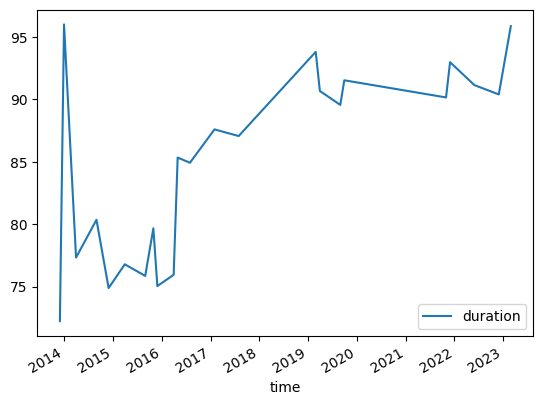

In [6]:
duration_plot = monthly_average[["time", "duration"]].mean().dropna()
duration_plot.plot()

/tmp/ipykernel_6850/683167702.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  survivingp_plot = monthly_average[["time", "survivingCount"]].mean().dropna()


<Axes: xlabel='time'>

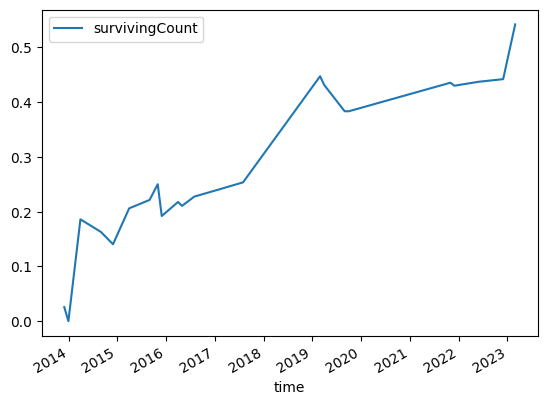

In [7]:
survivingp_plot = monthly_average[["time", "survivingCount"]].mean().dropna()
survivingp_plot.plot()

/tmp/ipykernel_6850/3828588760.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_average[['time', 'heDamage']].mean().dropna().plot()


<Axes: xlabel='time'>

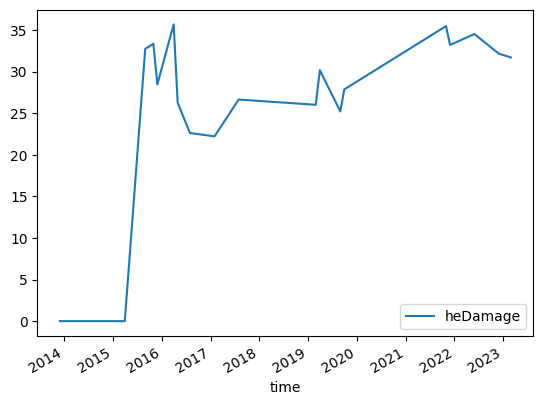

In [8]:
monthly_average[['time', 'heDamage']].mean().dropna().plot()

/tmp/ipykernel_6850/538616652.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  longestkill_plot = monthly_average[["time", "longestKillWaitS"]].mean().dropna()


<Axes: xlabel='time'>

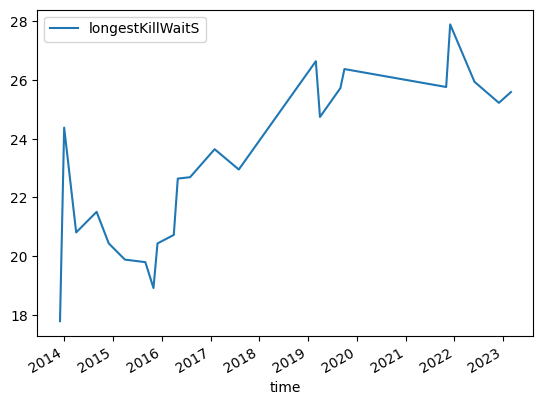

In [9]:
longestkill_plot = monthly_average[["time", "longestKillWaitS"]].mean().dropna()
longestkill_plot.plot()

/tmp/ipykernel_6850/3064090705.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_average[['time', 'lastKillToEndS']].mean().dropna().plot()


<Axes: xlabel='time'>

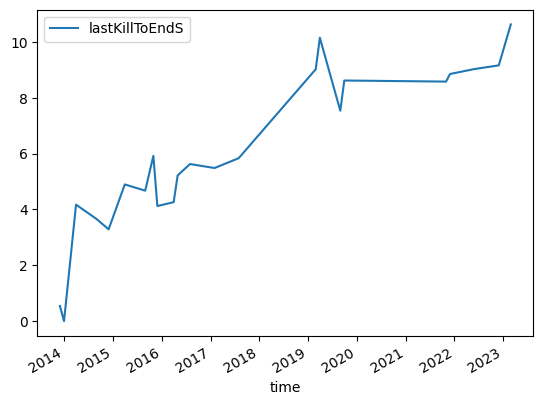

In [10]:
monthly_average[['time', 'lastKillToEndS']].mean().dropna().plot()

In [11]:
csgo_df.map.explode().value_counts().to_frame()

,map
de_inferno,3525
de_mirage,3306
de_overpass,2452
de_dust2,2439
de_nuke,2038
de_cbble,1579
de_train,1482
de_cache,1215
de_vertigo,877
de_ancient,783


# Calculating the players that save the most

In [12]:
survivingRounds = csgo_df.loc[csgo_df["survivingCount"] > 0]
survivingRounds
;

''

This is not a list of the most saved players - it is a list of players on teams that save the most. dupreeh might not have saved 235 times, but the teams he's been on have.

I would say that Jame and Qikert's position is quite notable. 

In [13]:
survivingRounds.losingPlayers.explode().value_counts().to_frame().reset_index().rename(columns={"index":"SteamID64", "losingPlayers": "roundsSaved"}).merge(players_df)[['name', 'roundsSaved']].groupby('roundsSaved').agg(list)

,name
roundsSaved,
1,"[Detrony #INTEL, HUNDEN, natu, deviaNt #COREX, KHRN, disturbed, stonde, xartE, racno-.`SGMF.<..>, cent #ALIENWARE, blackpoisoN #RAZER, AcilioN]"
2,"[desi, WOLF > astaRRRRR, WOLF > RiTz, WOLF > Mithil:D, WOLF > Ace, WOLF > R i X, oSee]"
3,"[ptr, steel * ADATA, ub1que, yam, zEVES, Polly * XTRFY]"
4,"[DEVIL, THREAT]"
5,"[rallen, Hyper, Furlan, koosta, pita, [R]eason EXR * SteelSeries, HS, zehN, innocent, suNny, peet, GruBy, [R]eason LOMME * SteelSeries]"
...,...
212,[Zeus]
216,[olofmeister]
228,[s1mple]


This is a list of players that have saved the most.

In [14]:
csgo_df["survivingPlayers"] = csgo_df.survivingPlayers.apply(lambda x: sorted(map(int, x[1:-1].split(','))) if x != 'null' else None)

In [15]:
savingPlayers = csgo_df.survivingPlayers.explode().value_counts().to_frame().reset_index(names="SteamID64").rename(columns={"survivingPlayers": "roundsSurvived"}).merge(players_df)
savingPlayers

,SteamID64,roundsSurvived,name,apps
0,76561198036125584,170,Jame,60
1,76561198034202275,101,s1mple,85
2,76561198004854956,101,dupreeh,126
3,76561198127236290,91,Qikert,60
4,76561198004115516,87,cadiaN,53
...,...,...,...,...
315,76561197987053545,1,ub1que,2
316,76561198172837021,1,rigoN,7
317,76561197980539257,1,DavCost,7
318,76561198003756239,1,jR,2


In [16]:
savingPlayers[['name', 'roundsSurvived']].groupby('roundsSurvived').agg(list)

,name
roundsSurvived,
1,"[HaRtsSsSsSs * ZOWIE GEAR, AcilioN, Professor_Chaos, STYKO, cent #ALIENWARE, [R]eason EXR * SteelSeries, zehN, DEVIL, zEVES, Golden, rallen, GruBy, innocent, xartE, SENER1, yam, LEGIJA, ub1que, rigoN, DavCost, jR, hooch]"
2,"[Hyper, pyth, fel1x *Platincasino, Furlan, smF, zqkS, koosta, iBP anger, AZK * ASRock, zonic, krystaLAW *Platincasino, Troubley * WorldofCDKeys.com, EPSILON Sf * GAMDIAS, oskar, abE, steel * ADATA, THREAT, Havoc[K] MSi, SPUNJ MSi, USTILO, suNny, WOLF > RiTz, keshandr, SIXER]"
3,"[lauNX, sinnopsyy, juanflatroo, LDLC.com KQLY Cooler Master, svyat, Zero, SnypeR, James, emagine, HS, keev, pita, spaze, swag * Intel]"
4,"[XANTARES, Zellsis, daps, CW Nico * Komplett, DaZeD Netcodeguides.com, Staehr, FNS, LDLC.com Uzzziii Cooler Master, arya, Lucky, gade, peet, mir, doto, cype * Gunnar Optics, zews, ANNIHILATION, speed4k, kinqie, fR11$HAAA]"
5,"[maden, Cloud9 CS seM <ALIENware>, JT, tiziaN, Pimp, disco doplan, Devilwalk.teg * Fragnet]"
...,...
82,[NAF]
87,[cadiaN]
91,[Qikert]


# Calculating the ratio of appearances within the dataset, and the amount they save

In [17]:
savingPlayers['mostSaved'] = savingPlayers['roundsSurvived']/savingPlayers['apps']

### Players with the lowest survival/appearances ratio

In [18]:
savingPlayers.loc[savingPlayers['apps'] > 20 ].sort_values(by='mostSaved').head(20)[['name', 'apps', 'roundsSurvived', 'mostSaved']]

,name,apps,roundsSurvived,mostSaved
234,Cloud9 CS seM <ALIENware>,28,5,0.178571
247,LDLC.com Uzzziii Cooler Master,22,4,0.181818
230,ANGE1,28,6,0.214286
114,friberg,87,19,0.218391
232,B1ad3,26,6,0.230769
133,dennis,67,16,0.238806
219,FeTiSh[MB],28,7,0.250000
214,MSL,26,7,0.269231
109,byali,78,21,0.269231
117,pronax,70,19,0.271429


### Players with the highest survival/appearances ratio

In [19]:
savingPlayers.loc[savingPlayers['apps'] > 20 ].sort_values(by='mostSaved', ascending=False).head(20)[['name', 'apps', 'roundsSurvived', 'mostSaved']]

,name,apps,roundsSurvived,mostSaved
0,Jame,60,170,2.833333
21,sh1ro,21,53,2.523810
8,frozen,34,72,2.117647
36,fame,25,45,1.800000
10,buster,39,68,1.743590
11,FL1T,40,68,1.700000
5,NAF,49,82,1.673469
50,oSee,23,38,1.652174
4,cadiaN,53,87,1.641509
60,Liazz,23,36,1.565217


<Axes: xlabel='time'>

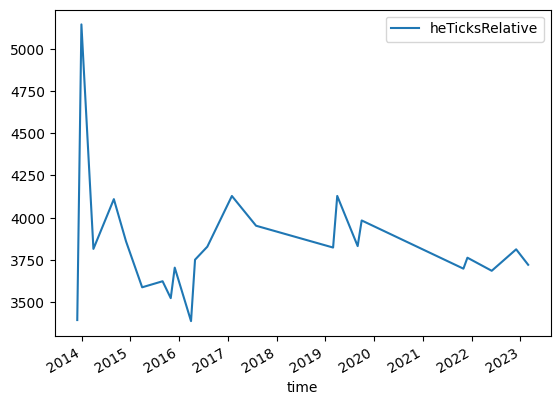

In [20]:
csgo_df[['time', 'heTicksRelative']].explode('heTicksRelative').resample("M", on="time").mean().dropna().plot()

In [21]:
csgo_df.losingPlayers.explode().value_counts().to_frame().reset_index().rename(columns={"index":"SteamID64", "losingPlayers": "roundsPlayed"}).merge(players_df)


,SteamID64,roundsPlayed,name,apps
0,76561198004854956,1352,dupreeh,126
1,76561197988627193,1276,olofmeister,115
2,76561197989744167,1256,apEX,101
3,76561198031651584,1190,KRIMZ,108
4,76561197987713664,1181,device,114
...,...,...,...,...
368,76561197969523758,2,Xapso ultra * Tesoro,2
369,76561198106952899,2,Zeus =D,2
370,76561198106938586,2,kibaken,2
371,76561197989686129,2,-F.C-* nyxJ|uK *,2


## Players that take the most amount of time to lose

In [22]:
durations = csgo_df.explode("losingPlayers").reset_index()[["duration", "losingPlayers"]].rename(columns={"losingPlayers": "SteamID64"}).merge(players_df)[["duration", "name", "apps"]]

### Players that took the least amount of time to lose

In [23]:
durations.groupby('name').agg(list).applymap(np.mean).sort_values(by='duration').head(30)

,duration,apps
name,,
SKYTTEN * Gunnar,56.000000,6.0
WOLF > Ace,58.218750,2.0
WOLF > astaRRRRR,58.218750,2.0
WOLF > Mithil:D,58.218750,2.0
WOLF > RiTz,58.218750,2.0
WOLF > R i X,58.218750,2.0
[R]eason COLON,58.500000,3.0
racno-.`SGMF.<..>,59.500000,2.0
blackpoisoN #RAZER,59.500000,2.0


### Players that took the most amount of time to lose

In [24]:
durations.groupby('name').agg(list).applymap(np.mean).sort_values(by='duration', ascending=False).head(30)

,duration,apps
name,,
HaRtsSsSsSs * ZOWIE GEAR,115.340909,6.000000
KaiR0N-,107.843373,13.000000
fitch,106.216495,7.000000
KrizzeN,106.216495,7.000000
fame,105.787456,25.000000
FL1T,105.079918,40.000000
Qikert,103.323138,60.000000
Jame,103.323138,60.000000
n0rb3r7,102.966942,12.000000
